In [1]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [2]:
import pandas as pd
import numpy as np


data_path = 'features_annotated.csv'
df = pd.read_csv(data_path)

### Create a mapping for the URLs

In [3]:
urlSet = set()
for u in df['url'].values:
    urlSet.add(u)

url2Idx = {}
for url in urlSet:
    url2Idx[url] = len(url2Idx)

In [ ]:
url2Idx

### Create a mapping for the labels

In [4]:
labelSet = set()
for l in df['label'].values:
    labelSet.add(l)

label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx)
labelEmbeddings = np.identity(len(label2Idx), dtype='float32')

In [110]:
class_weight = {
    label2Idx['Body']: 2.,
    label2Idx['Claim']: 15.,
    label2Idx['Credibility']: 15.,
    label2Idx['Date']: 15.,
    label2Idx['None']: 1.,
    label2Idx['Sources']: 3.,
    label2Idx['Title']: 15.,
}

In [ ]:
label2Idx

### Create a mapping for the tags

In [5]:
tagSet = set()
for t in df['tag'].values:
    tagSet.add(t)

tag2Idx = {}
for tag in tagSet:
    tag2Idx[tag] = len(tag2Idx)
tagEmbeddings = np.identity(len(tag2Idx), dtype='float32')

In [ ]:
tag2Idx

### Data to features

In [91]:
import ast


columns = ['url', 'label', 'tag', 'level', 'attrs']  # 0 url  1 label
features = {'tags': [], 'levels': [], 'attrs': [], 'labels': [], 'groups': []}

line = 0
last_group = ''

for data in df[columns].values:
    if last_group != data[0]:
        last_group = data[0]
        line = 0
    else:
        line += 1
    features['groups'].append(url2Idx[data[0]])
    #features['labels'].append(labelEmbeddings[label2Idx[data[1]]])
    features['labels'].append(label2Idx[data[1]])
    features['tags'].append(tagEmbeddings[tag2Idx[data[2]]])
    #features['labels'].append(data[1])
    #features['tags'].append(data[2])
    features['levels'].append([data[3], line])
    #features['levels'].append(levelEmbeddings[data[3]-1])
    features['attrs'].append(ast.literal_eval(data[4]))
features['tags'] = np.array(features['tags'])
features['levels'] = np.array(features['levels'])
features['labels'] = np.array(features['labels'])
features['groups'] = np.array(features['groups'])

### CSS classes feature

In [92]:
import re


features['css_classes'] = []

for attr in features['attrs']:
    if 'class' in attr:
        classes = attr['class']
        classes_ = []
        for clss in classes:
            classes_ += re.split('[\W_]+', clss)
        features['css_classes'].append(classes_)
    else:
        features['css_classes'].append([])

#### Create a mapping for the CSS classes

In [93]:
cssClassesSet = set()
for data in features['css_classes']:
    for clss in data:
        cssClassesSet.add(clss)

cssClasses2Idx = {}
for tag in cssClassesSet:
    cssClasses2Idx[tag] = len(cssClasses2Idx)

for i in range(len(features['css_classes'])):
    aux_m = np.zeros(len(cssClasses2Idx))
    for clss in features['css_classes'][i]:
        indx = cssClasses2Idx[clss]
        aux_m[indx] += 1
    features['css_classes'][i] = aux_m
features['css_classes'] = np.array(features['css_classes'])

### Util - Plot confusion matrix

In [94]:
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Dense Model

In [95]:
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate


def dense_model():
    tag_input = Input(shape=(tagEmbeddings.shape[0],))
    tag_ = Dense(64, activation='relu')(tag_input)
    tag_ = Dense(32, activation='relu')(tag_)

    level_input = Input(shape=(2,), dtype='float32')
    level_ = Dense(2, activation='relu')(level_input)
    
    css_classes_input = Input(shape=(len(cssClasses2Idx),))
    css_classes_ = Dense(512, activation='relu')(css_classes_input)
    css_classes_ = Dense(256, activation='relu')(css_classes_input)
    css_classes_ = Dense(128, activation='relu')(css_classes_)

    output = concatenate([tag_, level_, css_classes_])
    output = Dense(256, activation='relu')(output)
    output = Dense(128, activation='relu')(output)
    #output = Dense(len(label2Idx), activation='softmax')(output)
    output = Dense(len(label2Idx), activation='softmax')(output)

    model = Model(inputs=[tag_input, level_input, css_classes_input], outputs=[output])
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Cross Validation - Dense Model

In [ ]:
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

gp = GroupKFold(n_splits=5)
for train_indexs, test_indexs in gp.split(features['tags'], groups=features['groups']):
    
    tags_train = features['tags'][train_indexs]
    levels_train = features['levels'][train_indexs]
    cssClasses_train = features['css_classes'][train_indexs]
    X_train = [tags_train, levels_train, cssClasses_train]
    y_train = features['labels'][train_indexs]
    
    tags_test = features['tags'][test_indexs]
    levels_test = features['levels'][test_indexs]
    cssClasses_test = features['css_classes'][test_indexs]
    X_test = [tags_test, levels_test, cssClasses_test]
    y_test = features['labels'][test_indexs]

    groups_train = features['groups'][train_indexs]
    groups_test = features['groups'][test_indexs]
    train_g = set()
    test_g = set()
    for g in groups_train:
        train_g.add(g)
    for g in groups_test:
        test_g.add(g)
    print('Train Groups (URLs)', train_g)
    print('Test Groups (URLs)', test_g)
    
    model = KerasClassifier(build_fn=dense_model)
    model.fit(X_train, y_train, epochs=10, verbose=0) # class_weight=class_weight

    result = model.predict(X_test)
    #y_test = [r.tolist().index(1) for r in y_test]
    acc = accuracy_score(result, y_test)
    accuracy.append(acc)
    p = precision_score(result, y_test, average="macro")
    precision.append(p)
    r = recall_score(result, y_test, average="macro")
    recall.append(r)
    f = f1_score(result, y_test, average="macro")
    f1.append(f)
    confusion.append(confusion_matrix(result, y_test))
    
    print("%s: %.2f %%" % ('Acc', acc*100))
    print("%s: %.2f %%" % ('Precision', p*100))
    print("%s: %.2f %%" % ('Recall', r*100))
    print("%s: %.2f %%" % ('F1', f*100))
    print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

Train Groups (URLs) {0, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {1}
Acc: 88.63 %
Precision: 23.98 %
Recall: 37.46 %
F1: 26.98 %

Train Groups (URLs) {0, 1, 2, 3, 5, 6, 8, 9, 10}
Test Groups (URLs) {4, 7}
Acc: 90.68 %
Precision: 29.29 %
Recall: 26.62 %
F1: 27.77 %

Train Groups (URLs) {0, 1, 2, 4, 5, 6, 7, 8, 9}
Test Groups (URLs) {10, 3}


###### Dense - Confusion Matrix plot

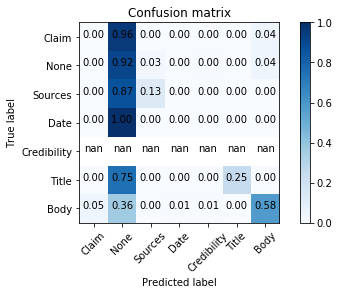

In [112]:
nc = []
for c in confusion:
    d = len(label2Idx) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, label2Idx.keys(), normalize=True)

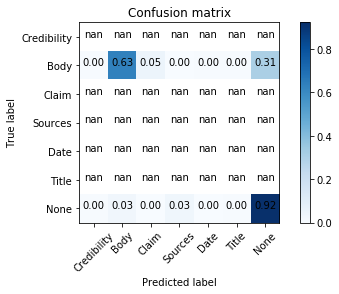

In [19]:
Tag + Levels

### LSTM model

In [13]:
from keras.models import Model, Sequential
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate,Concatenate


def lstm_model_working():
    input_tags = Input(shape=(None, tagEmbeddings.shape[0]))
    lstm_tags = LSTM(150)(input_tags)
    output = Dense(len(label2Idx))(lstm_tags)
    model = Model(inputs=[input_tags], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    #model.summary()
    return model

def lstm_model():
    input_tags = Input(shape=(None, tagEmbeddings.shape[0]))
    lstm_tags = LSTM(150)(input_tags)
    
    input_levels = Input(shape=(None, levelEmbeddings.shape[0]))
    lstm_levels = LSTM(150)(input_levels)
    
    output = concatenate([lstm_tags, lstm_levels])
    output = Dense(len(label2Idx))(output)
    model = Model(inputs=[input_tags, input_levels], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    #model.summary()
    return model

#### Cross Validation - LSTM Model

In [66]:
from sklearn.model_selection import GroupKFold
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix


accuracy = []
precision = []
recall = []
f1 = []
confusion = []

gp = GroupKFold(n_splits=8)
for train_indexs, test_indexs in gp.split(features['tags'], groups=features['groups']):
    
    #_trains = {}
    #for i in train_indexs:
    #    group_ = features['groups'][i]
    #    tag_ = features['tags'][i]
    #    level_ = features['levels'][i]
    #    label_ = features['labels'][i]
    #    if group_ not in _trains:
    #        _trains[group_] = [[], [], []]
    #    _trains[group_][0].append(tag_)
    #    _trains[group_][1].append(level_)
    #    _trains[group_][2].append(label_)

    #X_train = [[np.array(_trains[x][0]), np.array(_trains[x][1])] for x in _trains]
    #y_train = [np.array(_trains[y][-1]) for y in _trains]
    
    
    tags_train = features['tags'][train_indexs]
    tags_train = tags_train.reshape((tags_train.shape[0], 1, tags_train.shape[1])) # Test
    levels_train = features['levels'][train_indexs]
    levels_train = levels_train.reshape((levels_train.shape[0], 1, levels_train.shape[1])) # Test
    X_train = [tags_train, levels_train]
    y_train = features['labels'][train_indexs]
    
    tags_test = features['tags'][test_indexs]
    tags_test = tags_test.reshape((tags_test.shape[0], 1, tags_test.shape[1])) # Test
    levels_test = features['levels'][test_indexs]
    levels_test = levels_test.reshape((levels_test.shape[0], 1, levels_test.shape[1])) # Test
    X_test = [tags_test, levels_test]
    y_test = features['labels'][test_indexs]

    groups_train = features['groups'][train_indexs]
    groups_test = features['groups'][test_indexs]
    train_g = set()
    test_g = set()
    for g in groups_train:
        train_g.add(g)
    for g in groups_test:
        test_g.add(g)
    print('Train Groups (URLs)', train_g)
    print('Test Groups (URLs)', test_g)
    
    #model = KerasClassifier(build_fn=lstm_model)
    model.fit(X_train, y_train, epochs=5, verbose=0)
    #model.fit(tags_train, y_train, epochs=5, verbose=0)

    result = model.predict(X_test)
    #result = model.predict(tags_test)
    y_test = [r.tolist().index(1) for r in y_test]
    acc = accuracy_score(result, y_test)
    accuracy.append(acc)
    p = precision_score(result, y_test, average="macro")
    precision.append(p)
    r = recall_score(result, y_test, average="macro")
    recall.append(r)
    f = f1_score(result, y_test, average="macro")
    f1.append(f)
    confusion.append(confusion_matrix(result, y_test))
    
    print("%s: %.2f %%" % ('Acc', acc*100))
    print("%s: %.2f %%" % ('Precision', p*100))
    print("%s: %.2f %%" % ('Recall', r*100))
    print("%s: %.2f %%" % ('F1', f*100))
    print('')

print("Acc %.2f %% (+/- %.2f %%)" % (np.mean(accuracy)*100, np.std(accuracy)*100))
print("Precision %.2f %% (+/- %.2f %%)" % (np.mean(precision)*100, np.std(precision)*100))
print("Recall %.2f %% (+/- %.2f %%)" % (np.mean(recall)*100, np.std(recall)*100))
print("F1 %.2f %% (+/- %.2f %%)" % (np.mean(f1)*100, np.std(f1)*100))

Train Groups (URLs) {0, 1, 2, 3, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {4}
Acc: 75.57 %
Precision: 12.52 %
Recall: 12.17 %
F1: 12.34 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 6, 8, 9, 10}
Test Groups (URLs) {7}
Acc: 0.40 %
Precision: 1.53 %
Recall: 0.34 %
F1: 0.56 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 7, 8, 9, 10}
Test Groups (URLs) {6}
Acc: 96.48 %
Precision: 14.29 %
Recall: 13.78 %
F1: 14.03 %

Train Groups (URLs) {0, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {1}
Acc: 86.29 %
Precision: 14.29 %
Recall: 12.33 %
F1: 13.23 %

Train Groups (URLs) {0, 1, 3, 4, 5, 6, 7, 8, 9, 10}
Test Groups (URLs) {2}
Acc: 56.56 %
Precision: 33.72 %
Recall: 15.99 %
F1: 13.79 %

Train Groups (URLs) {0, 1, 2, 3, 4, 5, 6, 7, 9}
Test Groups (URLs) {8, 10}
Acc: 88.68 %
Precision: 14.29 %
Recall: 12.67 %
F1: 13.43 %

Train Groups (URLs) {0, 1, 2, 4, 6, 7, 8, 9, 10}
Test Groups (URLs) {3, 5}
Acc: 34.32 %
Precision: 33.36 %
Recall: 15.19 %
F1: 12.49 %

Train Groups (URLs) {1, 2, 3, 4, 5, 6, 7, 8, 10}
Tes

###### LSTM - Confusion Matrix plot

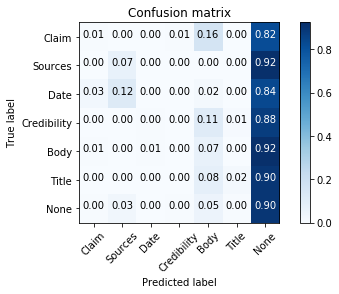

In [67]:
nc = []
for c in confusion:
    d = len(label2Idx) - len(c)
    c = np.pad(c, (0,d), 'constant')
    nc.append(c)
confusion = nc
cm = np.mean(confusion, axis=0)
plot_confusion_matrix(cm, label2Idx.keys(), normalize=True)